In [1]:
import tensorflow as tf 
tf.test.gpu_device_name()

''

In [2]:
from google.colab import files
upload = files.upload()

Saving 3-class.csv to 3-class.csv


In [3]:
up_list = files.upload()

Saving list.txt to list.txt


In [4]:
!mkdir outputs
!pip3 install keras_metrics

In [0]:
# -*- coding: utf-8 -*-
#-------------------------------------------------------------------------------

import itertools
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


import re
from keras import regularizers
import sys
import codecs
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
#from nltk.stem.arlstem import ARLSTem
import gensim
from gensim.models.word2vec import Word2Vec


import keras
from keras import layers
from keras import optimizers

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import to_categorical
import keras_metrics
from keras.layers import Embedding
from sklearn.model_selection import train_test_split

from keras.engine.topology import Layer

In [36]:
from keras.utils import get_file
cbow = get_file('cbow_100.zip', 'https://archive.org/download/aravec2.0/tweet_cbow_100.zip', extract=True)
cbow

'/root/.keras/datasets/cbow_100.zip'

In [37]:
!ls /root/.keras/datasets/

cbow_100.zip	 tweets_cbow_100.trainables.syn1neg.npy
tweets_cbow_100  tweets_cbow_100.wv.vectors.npy


In [0]:
from pathlib import Path
cbow_path = Path('/root/.keras/datasets/tweets_cbow_100')

In [0]:
import keras.backend as K
K.clear_session()

In [40]:
data = pd.read_csv('3-class.csv', encoding='utf-8')
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(56674, 2)


,Tweet,Polarity
0,تعليق_الدراسه_في_القصيم عزام شكله يحب قصيميه,neg
1,اتوقع ان يتم تعليق الدراسه في منطقه الرياض بع...,neut
2,الهلال_هجر الف مبروك يازعماا ولكن اتمنى فرحه ...,pos
3,لا داعي لان يبحث الهلال عن اي انجاز كل بطوله ...,pos
4,هدد تنظيم داعش باستهداف علماا الازهر بعد تكفير...,neg


In [41]:
data.sample(frac=1)

,Tweet,Polarity
7090,5لي هلال انا عاجز عن التعبير الهلال_هجر,neut
31282,رجال_الحد_الجنوبي الحد_الجنوبي اللهم امنا في ...,pos
45946,الكورهالايطاليه انهارت من سنوات باستثناا العمل...,neg
35886,معرض الصور صور مباراه برشلونه روما برشلونه_روما,neut
32806,قطن غرب مدينه بريده تعليق_الدراسه_في_القصيم,neut
...,...,...
42378,النصر_الاتحاد فين راح هياط الخدم نبغى نفوز عل...,neg
51686,عنوان المباراه باختصار وفرق الامنيات بين المل...,neut
3320,المرداسي يثبت انه فاشل ومتساهل مع خشونه لاعبي...,neg
29967,مبروك عوده روح البطل مبروك لعشاق النصر ورموزه...,pos


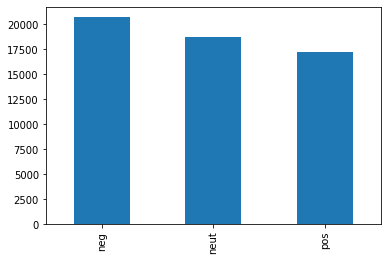

In [42]:
data['Polarity'].value_counts().sort_index().plot.bar()

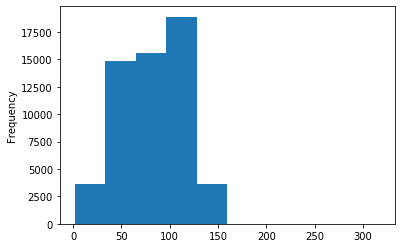

In [43]:
data['Tweet'].str.len().plot.hist()

In [44]:
def transform(x):
    if x == 'neg':
        return 0
    elif x == 'pos':
        return 1
    return 2
data['Sentiment'] = data['Polarity'].apply(transform)
data.head()

,Tweet,Polarity,Sentiment
0,تعليق_الدراسه_في_القصيم عزام شكله يحب قصيميه,neg,0
1,اتوقع ان يتم تعليق الدراسه في منطقه الرياض بع...,neut,2
2,الهلال_هجر الف مبروك يازعماا ولكن اتمنى فرحه ...,pos,1
3,لا داعي لان يبحث الهلال عن اي انجاز كل بطوله ...,pos,1
4,هدد تنظيم داعش باستهداف علماا الازهر بعد تكفير...,neg,0


In [45]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [46]:
#remove users
data['clean'] = data['Tweet'].apply(lambda x: re.sub('(@[A-Za-z]+)', '', x, flags=re.UNICODE))

#remove hashtags
#data['clean'] = data['clean'].apply(lambda x: re.sub('([أ-ي]+_[أ-ي]+)', '', x, flags=re.UNICODE))
#data['clean'] = data['clean'].apply(lambda x: re.sub('(_[أ-ي]+)', '', x, flags=re.UNICODE))
data['clean'] = data['clean'].apply(lambda x: re.sub('(_)', ' ', x, flags=re.UNICODE))
#remove letters, numbers & symbols
data['clean'] = data['clean'].apply(lambda x: re.sub('[a-zA-Z0-9@=$:.،%^*"#~£/&\n؟?!-_]', '', x, flags=re.UNICODE))

#arabic numbers
data['clean'] = data['clean'].apply(lambda x: re.sub('[٠١٢٣٤٥٦٧٨٩]', '', x, flags=re.UNICODE))

#nltk tokenize
data['clean'].apply(word_tokenize)
data['clean'] = data['clean'].apply(word_tokenize) 

#repeated letters
data['clean']= data['clean'].apply(lambda x: [''.join(ch for ch, _ in itertools.groupby(y)) for y in x])

#normalization
def normalizeArabic(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    return(text)
data['clean']= data['clean'].apply(lambda x: [normalizeArabic(y) for y in x])

#remove stopwords
def get_stop_words():
    path = 'list.txt'
    stop_words = []
    with codecs.open(path, "r", encoding="utf-8", errors="ignore") as myfile:
        stop_words = myfile.readlines()
    stop_words = [word.strip() for word in stop_words]
    return stop_words

stop_words = get_stop_words()
data['clean']= data['clean'].apply(lambda x: [item for item in x if item not in stop_words])

#remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['clean']= data['clean'].apply(lambda x: [remove_emoji(y) for y in x])

data.head(10)

,Tweet,Polarity,Sentiment,clean
0,تعليق_الدراسه_في_القصيم عزام شكله يحب قصيميه,neg,0,"[تعليق, الدراسه, القصيم, عزام, شكله, يحب, قصيميه]"
1,اتوقع ان يتم تعليق الدراسه في منطقه الرياض بع...,neut,2,"[اتوقع, يتم, تعليق, الدراسه, منطقه, الرياض, نص..."
2,الهلال_هجر الف مبروك يازعماا ولكن اتمنى فرحه ...,pos,1,"[الهلال, هجر, مبروك, يازعما, اتمني, فرحه, الفو..."
3,لا داعي لان يبحث الهلال عن اي انجاز كل بطوله ...,pos,1,"[داعي, لان, يبحث, الهلال, انجاز, بطوله, تصادف,..."
4,هدد تنظيم داعش باستهداف علماا الازهر بعد تكفير...,neg,0,"[هد, تنظيم, داعش, باستهداف, علما, الازهر, تكفي..."
5,تعليم المجمعه تنضم لقافله تعليق_الدراسه ليوم ...,neut,2,"[تعليم, المجمعه, تنضم, لقافله, تعليق, الدراسه,..."
6,صوره معبره عن فراق زميل في ميادين الشرف وليس ...,pos,1,"[صوره, معبره, فراق, زميل, ميادين, الشرف, ضياع,..."
7,السماح_بالسينما_في_السعوديه ثالثا واخيرا اتمن...,neg,0,"[السماح, بالسينما, السعوديه, ثالثا, واخيرا, ات..."
8,واسطه اكيد راشين الحكم ضربتين جزاا غير مستحقه ...,neg,0,"[واسطه, اكيد, راشين, الحكم, ضربتين, جزا, مستحق..."
9,كلمه_لشركات_الاتصالات الله ياخذ حقي منكم في ك...,neg,0,"[كلمه, لشركات, الاتصالات, اله, ياخذ, حقي, منكم..."


In [47]:
CBOW = Word2Vec.load(str(cbow_path))
CBOWE = CBOW.wv.get_keras_embedding()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
y = to_categorical(data['Sentiment'].values)

In [49]:
tokenizer = Tokenizer(num_words=len(data['clean']), split=" ")
tokenizer.fit_on_texts(data['clean'].values)

X = tokenizer.texts_to_sequences(data['clean'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     4,     5,     9,    82,  2059,  1750,  6358],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,   451,   383,
            4,     5,   432,    26,  1177,   469,     4,     5,    26],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     1,    18,    12,   407,   187,   582,    44, 15158,
         3619,    58,  1651,    88,    18,  6359,   733,   601,  9986],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,  1041,   201,  2585,
            1,  5938,   155, 24258, 11265, 15159, 35697, 24259, 35698],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,  5516,   395,    46,
  

In [50]:
X.shape

(56674, 27)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
#Metrics
def plot_data(H, EPOCHS, name='figure.png'):
    # plot the losses
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, EPOCHS), H['acc'],
        label="Accuracy")
    plt.plot(np.arange(0, EPOCHS), H['val_acc'],
        label="Val_Accuracy")
    plt.plot(np.arange(0, EPOCHS), H['loss'],
        label="Loss")
    plt.plot(np.arange(0, EPOCHS), H['val_loss'],
        label="Val_Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy & Loss")
    plt.legend(loc="upper right")
    plt.show()
    if name:
        plt.savefig(name)

In [0]:
#calculation
from keras import backend as K


# calculate f score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
# metrics all
metrics = [
    'accuracy',
    keras_metrics.precision(),
    keras_metrics.recall(),
    f1,
]

In [0]:
# hyperparamters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2
EPOCHS = 20

In [0]:
#build model
def buildAndRunModel(model, ckpt_path):
    # callbacks
    checkpoints = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, save_weights_only=False)
    
    model.compile(loss='categorical_crossentropy', 
                   optimizer='adam',
                   metrics=metrics,)
    H = model.fit(X_train, y_train, 
               validation_split=VALIDATION_SPLIT, 
               batch_size=BATCH_SIZE, 
               epochs=EPOCHS,
               callbacks=[checkpoints],)
    return H

In [0]:
def eval_model(model):
    E = model.evaluate(X_test, y_test)
    return list(zip(E, model.metrics_names))

In [0]:
#GRU

gru_model_input = layers.Input(shape=(X_train.shape[1],))
x = CBOWE(gru_model_input)
#x = layers.GRU(100, return_sequences=True, dropout=0.5)(x)
x = layers.Bidirectional(layers.GRU(100, return_sequences=True, dropout=0.5))(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation='relu', name='desne1')(x)
x = layers.Dense(3, activation='softmax', name='desne_output')(x)

gru_model = keras.models.Model(inputs=gru_model_input, outputs=x)

In [59]:
gru_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 27)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 27, 100)           33167900  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 27, 200)           120600    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5400)              0         
_________________________________________________________________
desne1 (Dense)               (None, 100)               540100    
_________________________________________________________________
desne_output (Dense)         (None, 3)                 303       
Total params: 33,828,903
Trainable params: 661,003
Non-trainable params: 33,167,900
_________________________________________

In [60]:
%%time
GRU_H = buildAndRunModel(gru_model, 'gru_ckpt')

Train on 36271 samples, validate on 9068 samples
Epoch 1/20
36271/36271 [==============================] - 72s 2ms/step - loss: 1.0091 - acc: 0.4835 - precision: 0.5567 - recall: 0.2071 - f1: 0.2974 - val_loss: 0.8611 - val_acc: 0.5996 - val_precision: 0.6525 - val_recall: 0.5024 - val_f1: 0.5570
Epoch 2/20
36271/36271 [==============================] - 71s 2ms/step - loss: 0.8845 - acc: 0.5842 - precision: 0.6324 - recall: 0.4545 - f1: 0.5206 - val_loss: 0.8187 - val_acc: 0.6373 - val_precision: 0.6682 - val_recall: 0.6143 - val_f1: 0.6125
Epoch 3/20
36271/36271 [==============================] - 71s 2ms/step - loss: 0.8395 - acc: 0.6162 - precision: 0.6600 - recall: 0.5207 - f1: 0.5721 - val_loss: 0.8027 - val_acc: 0.6530 - val_precision: 0.7036 - val_recall: 0.5617 - val_f1: 0.6258
Epoch 4/20
36271/36271 [==============================] - 71s 2ms/step - loss: 0.8168 - acc: 0.6280 - precision: 0.6747 - recall: 0.5364 - f1: 0.5906 - val_loss: 0.8036 - val_acc: 0.6565 - val_precision: 

In [61]:
eval_model(gru_model)

11335/11335 [==============================] - 5s 422us/step


[(0.7846648727422461, 'loss'),
 (0.680811645362048, 'acc'),
 (0.7365145227997477, 'precision'),
 (0.5980746088905398, 'recall'),
 (0.6719706109929937, 'f1')]

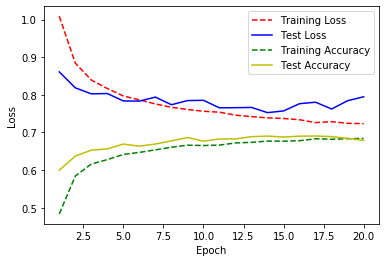

In [63]:
training_loss = GRU_H.history['loss']
test_loss = GRU_H.history['val_loss']
training_acc = GRU_H.history['acc']
test_acc = GRU_H.history['val_acc']
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.plot(epoch_count, training_acc, 'g--')
plt.plot(epoch_count, test_acc, 'y-')
plt.legend(['Training Loss', 'Test Loss', 'Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();